In [34]:
import numpy as np 
import pandas as pd 

In [35]:
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM #This is giving an error while importing 
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization,Conv1D,MaxPooling1D
# from tensorflow.keras import layers # Added due to error in recurrent layer import
from keras.models import Sequential, load_model, save_model
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

### Loading Dataset

In [36]:
df = pd.read_csv("my_data.csv")
plot_x = df['Date'].copy()
df.set_index("Date", inplace = True)
df.index = pd.to_datetime(df.index)
df.head()
# print(df.columns.tolist())

,Open,High,Low,Close,Volume
Date,,,,,
2012-11-26 00:00:00+05:30,5648.649902,5649.200195,5623.450195,5635.899902,0
2012-11-27 00:00:00+05:30,5658.500000,5733.200195,5658.000000,5727.450195,0
2012-11-29 00:00:00+05:30,5736.700195,5833.500000,5736.100098,5825.000000,0
2012-11-30 00:00:00+05:30,5836.000000,5885.250000,5827.850098,5879.850098,0
2012-12-03 00:00:00+05:30,5878.250000,5899.149902,5854.600098,5870.950195,0


In [37]:
# data=[{
#     "Open":1629.70,
#     "Close": 160.00,
#     "High":1631.70,
#     "Low":114.10,
#     "Volume": 1692315,
#     "Date" : 25-11-2022
# }]

In [38]:
# df=pd.DataFrame(data)
# print(df)
# df.set_index("Date", inplace = True)
# df.index = pd.to_datetime(df.index)
# df.head()

In [39]:
print(type(plot_x))

<class 'pandas.core.series.Series'>


### Predicting Prices

In [40]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x = df[['Open', 'Low', 'High', 'Volume']].copy()
y = df['Close'].copy()

x [['Open', 'Low', 'High', 'Volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [41]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [42]:
window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (X_train[0], y_train[0])

(2186, 22, 5) (2186,) (243, 22, 5) (243,)
[[0.03105713 0.03786455 0.02494967 0.         0.02659934]
 [0.03179393 0.04045713 0.03127176 0.         0.03353915]
 [0.03764334 0.04631766 0.03882062 0.         0.04093374]
 [0.04507101 0.05320246 0.04271548 0.         0.04509156]
 [0.04823133 0.05520975 0.04376162 0.         0.04441691]
 [0.04737485 0.05553991 0.04344554 0.         0.0458041 ]
 [0.05035193 0.05796742 0.04516527 0.         0.04665689]
 [0.05182548 0.05403163 0.04702803 0.         0.0489613 ]
 [0.05240146 0.0577648  0.04757747 0.         0.04717992]
 [0.05105877 0.05772355 0.04532711 0.         0.04729362]
 [0.05163848 0.05602393 0.04872898 0.         0.046528  ]
 [0.05118967 0.05668425 0.04567708 0.         0.04570934]
 [0.04988443 0.05421549 0.04438633 0.         0.04294253]
 [0.04588633 0.05405039 0.04277946 0.         0.04507261]
 [0.04690362 0.05487581 0.04277567 0.         0.04342766]
 [0.04788352 0.05284977 0.04426211 0.         0.0463764 ]
 [0.05115227 0.0594269  0.0467

In [43]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
model = build_model(input_shape=(window, 5))

In [45]:
model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
69/69 [==============================] - 14s 81ms/step - loss: 0.0238 - accuracy: 9.1491e-04
Epoch 2/5
69/69 [==============================] - 6s 84ms/step - loss: 0.0012 - accuracy: 9.1491e-04
Epoch 3/5
69/69 [==============================] - 6s 92ms/step - loss: 0.0010 - accuracy: 9.1491e-04
Epoch 4/5
69/69 [==============================] - 6s 90ms/step - loss: 0.0014 - accuracy: 9.1491e-04
Epoch 5/5
69/69 [==============================] - 6s 85ms/step - loss: 9.0797e-04 - accuracy: 9.1491e-04


In [46]:
save_model(model, "model.h5")

In [47]:
model = load_model("model.h5")

In [48]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

8/8 [==============================] - 0s 41ms/step


In [49]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [50]:
type(testPredict)

numpy.ndarray

In [51]:
plot_predicted = testPredict.copy()
# print(plot_predicted.shape)
# plot_predicted = plot_predicted.reshape(145, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(243, 1)
print(plot_actual.shape)
# print(plot_predicted.shape)

(243, 1)


In [52]:
plot_x = pd.to_datetime(plot_x.iloc[-174:])

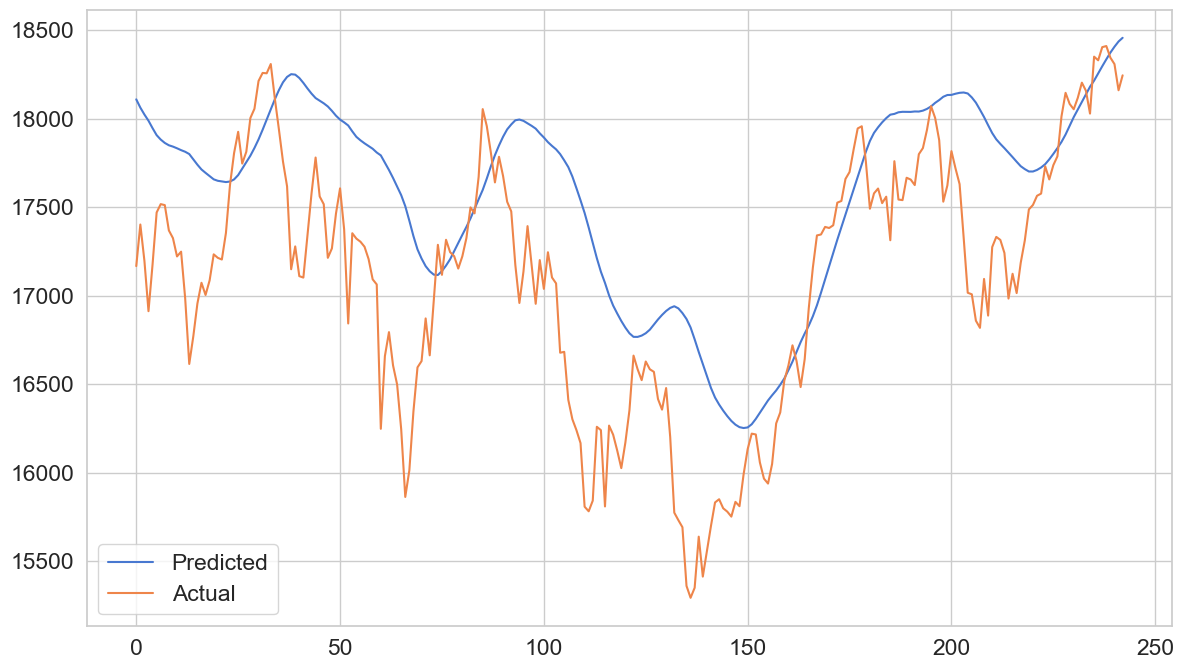

In [53]:
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

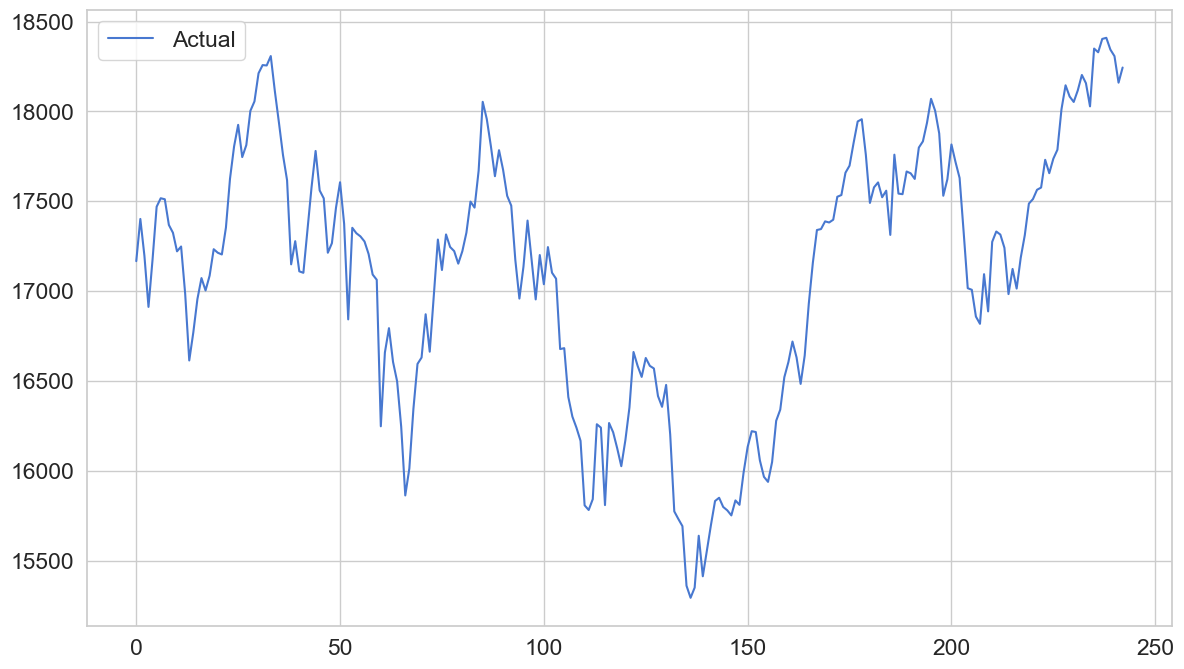

In [54]:
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [55]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 273.45 RMSE
Test Score: 664.76 RMSE


### Plotting Results

In [56]:
nifty_stock_prices = df["Close"].values.astype('float32')
nifty_stock_prices = nifty_stock_prices.reshape(len(nifty_stock_prices), 1)

In [57]:
trainPredictPlot = np.empty_like(nifty_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

testPredictPlot = np.empty_like(nifty_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(nifty_stock_prices) - testPredict.shape[0]):len(nifty_stock_prices), :] = testPredict

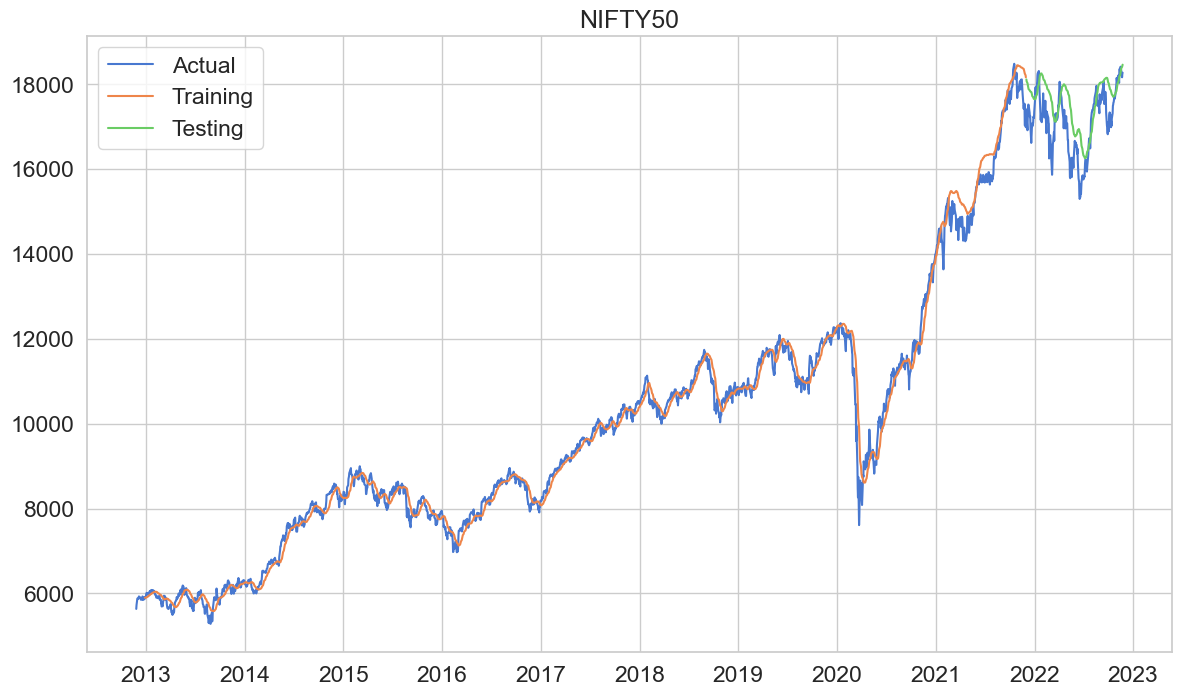

In [58]:
plt.plot(pd.DataFrame(nifty_stock_prices, columns=["Close"], index=df.index).Close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["Close"], index=df.index).Close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["Close"], index=df.index).Close, label='Testing')
plt.legend(loc='best')
plt.title("NIFTY50")
plt.show()